**Задание для поступления на кафедру Системного Программирования**

В данном блокноте представлено решение задания для поступления на кафедру Системного Программирования. Задание состояло из нескольких этапов:


1.   Реализация свёрточной нейронной сети на основе библиотеки PyTorch, используя датасет Cifar-10;
2. Реализация оптимизатора Adam на основе статьи "ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION";
3. Обучение нейронной сети, используя написанный оптимизатор Adam;
4. Проведение обучения, используя оптимизатор SGD из библиотеки PyTorch;
5. Анализ полученных результатов обучений и представление результатов на графиках, используя библиотеку Matplotlib;
6. Добавление к тренировочным данным шума и проведения обучения модели на них, далее аналогичный анализ моделей в зависимости от выбранного оптимизатора.



Изначально, подключаем все необходимые библиотеки и импортируем необходимые функции для удобства:

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

Теперь напишем 3 функции:

Сначала пишем функцию обучения модели на тренировочных данных. Здесь мы пользуемся стандартным алгоритмом обучения: обнуление градиента, подсчёт результата работы нейронной сети на входных данных, подсчёт функции потерь и проведение шага оптимизатора. Выходные же данные будем записывать в отдельный файл, чтобы была возможность позже их просмотреть:

In [2]:
def train_loop(data, model, func_loss, optimizer, f):
    size = len(data.dataset)

    model.train()
    running_loss = 0.0
    for batch, (inputs, labels) in enumerate(data, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = func_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch + 1) % 2500 == 0:
            print(f"loss: {running_loss / 2000:>7f}  [{(batch + 1) * batch_size:>5d}/{size:>5d}]", file = f)
            running_loss = 0.0

Второй функцией является крайне похожая функция тестирования нашей модели. Здесь мы расчитываем точность и ошибку модели, используя в качестве метрики точности отношение количества правильных ответов модели к общему количеству данных. Аналогично предыдущей функции, для удобства будем выводить некоторые промежуточные данные в отдельный файл, а также, для последующего графического представления работы модели, будем возвращать параметры точности и ошибки:

In [3]:
def test_loop(data, model, func_loss, f):
    correct = 0
    total = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for (inputs, labels) in data:
            outputs = model(inputs)
            test_loss += func_loss(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    loss = test_loss / (total / batch_size)
    print('Accuracy of the network on the 10000 test images: %d %%, loss: %.7f' % (accuracy, loss), file = f)
    return accuracy, loss

И наконец, реализуем последнюю функцию. Здесь мы будем создавать сразу 2 модели нейронной сети, каждая из которых будет работать со своим оптимизатором. Далее будем запускать обучение в виде цикла, и в конце будет происходить вызов функции для представления работы моделей на графиках. И, конечно, не забываем о сохранении моделей:

In [4]:
def train_and_test(dataload_train, dataload_test, noise = ""):
    model_adam = NeuralNetworks()
    model_sgd = NeuralNetworks()

    loss_func = nn.CrossEntropyLoss()
    optimizer_adam = Adam(model_adam.parameters(), alpha = learn_rate)
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr = learn_rate, momentum = momentum)

    loss_mas = [[0] * epoch for i in range(2)]
    accuracy_mas = [[0] * epoch for i in range(2)]

    f_adam = open("output_adam" + noise + ".txt", 'w')
    f_sgd = open("output_sgd" + noise + ".txt", 'w')

    for ep in range(epoch):
        print(f"Epoch {ep + 1}")
        print(f"Epoch {ep + 1}\n-------------------------------", file = f_adam)
        print(f"Epoch {ep + 1}\n-------------------------------", file = f_sgd)
        train_loop(dataload_train, model_adam, loss_func, optimizer_adam, f_adam)
        accuracy_mas[0][ep], loss_mas[0][ep] = test_loop(dataload_test, model_adam, loss_func, f_adam)
        print("Accuracy Adam: ", accuracy_mas[0][ep])
        train_loop(dataload_train, model_sgd, loss_func, optimizer_sgd, f_sgd)
        accuracy_mas[1][ep], loss_mas[1][ep] = test_loop(dataload_test, model_sgd, loss_func, f_sgd)
        print("Accuracy SGD: ", accuracy_mas[1][ep])

    f_adam.close()
    f_sgd.close()

    visualization(loss_mas, accuracy_mas, noise)

    torch.save(model_adam, "model_adam" + noise + ".pth")
    torch.save(model_sgd, "model_sgd" + noise + ".pth")

Здесь мы реализуем функцию для представления полученных данных работы моделей в виде 2-х графиков, а также сохранение этих графиков:

In [5]:
def visualization(loss_mas, accuracy_mas, noise):
    x = range(1, epoch + 1)
    figure = plt.figure()
    pdf = PdfPages("graph" + noise + ".pdf")
    plt.title("Analysis of the neural network operation depending on the selected optimizer on the" + noise + "data")
    plt.axis('off')
    plt.tight_layout()
    plt.subplot(1, 2, 1)
    plt.plot(x, loss_mas[0], label = "Adam")
    plt.plot(x, loss_mas[1], label = "SGD")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks(range(1, epoch + 1))
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, accuracy_mas[0], label = "Adam")
    plt.plot(x, accuracy_mas[1], label = "SGD")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.xticks(range(1, epoch + 1))
    plt.legend()
    pdf.savefig(bbox_inches='tight')
    plt.show()
    pdf.close()

Теперь мы готовы перейти к написанию классов. Первым классом будет класс, представляющий собой устройство нашей нейронной сети. В нём мы будем использовать 3 свёрточных и 3 линейных слоя:

In [6]:
class NeuralNetworks(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, input):
        output = self.network(input)
        return output

Вторым же классом будет класс реализации оптимизатора Adam из статьи "ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION". Фактически, реализована функция step(), остальное (кроме __init__) напрямую наследуется от класса torch.optim.Optimizer:

In [7]:
class Adam(optim.Optimizer):
    def __init__(self, param, alpha = 1e-3, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
        self.param = list(param)
        number_of_param = sum([par.numel() for par in self.param])
        self.t = 0
        self.m = [0] * number_of_param
        self.v = [0] * number_of_param
        defaults = dict(lr=alpha, betas=(beta1, beta2), eps=eps)
        super().__init__(self.param, defaults)
        # self.alpha = alpha
        # self.beta1 = beta1
        # self.beta2 = beta2
        # self.eps = eps

    def step(self):
        self.t += 1
        i = 0
        for group in self.param_groups:
          alpha, eps = group['lr'], group['eps']
          beta1, beta2 = group['betas']
          for par in group['params']:
            gt = par.grad.data
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * gt
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (gt ** 2)
            mt = self.m[i] / (1 - beta1 ** self.t)
            vt = self.v[i] / (1 - beta2 ** self.t)
            par.data = par.data - alpha * mt / (vt ** 0.5 + eps)
            i += 1

Здесь мы объявим наши гиперпараметры, нужные в дальнейшем, чтобы регулировать работу наших моделей, изменять скорость обучения для достижения максимальной тоности в конце:

In [8]:
batch_size = 4
learn_rate = 1e-3
epoch = 10
momentum = 0.9

Теперь мы наконец готовы работать с загрузкой данных. Для начала, напишем параметры трансформации данных. Исходные картинки мы будем сразу переводить в формат tensor, присущий библиотеке torch, далее нормализовывать стандартным образом. И здесь же напишем "зашумленный" трансформатор, который к тому же будет иметь lambda-функцию, добавляющую к исходным данным шум с L-infinity нормой не превосходящей 0.1:

In [9]:
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train_noise = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Lambda(lambda x: x + 0.2 * torch.rand_like(x) - 0.1)])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Далее, подгружаем данные и разбиваем их на партии по batch_size картинок в каждой:

In [10]:
data_train = datasets.CIFAR10(root = "./dataset", train = True, download = True, transform = transform_train)
data_train_noise = datasets.CIFAR10(root = "./dataset", train = True, download = True, transform = transform_train_noise)
data_test = datasets.CIFAR10(root = "./dataset", train = False, download = True, transform = transform_test)

dataload_train = DataLoader(data_train, batch_size = batch_size, shuffle = True)
dataload_train_noise = DataLoader(data_train_noise, batch_size = batch_size, shuffle = True)
dataload_test = DataLoader(data_test, batch_size = batch_size, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Теперь мы полностью готовы к обучению наших моделей. Для этого сначала вызовем функцию создания и обучения модели на неиспорченных тренировочных данных:

Epoch 1
Accuracy Adam:  62.81
Accuracy SGD:  54.13
Epoch 2
Accuracy Adam:  69.55
Accuracy SGD:  65.87
Epoch 3
Accuracy Adam:  69.43
Accuracy SGD:  69.74
Epoch 4
Accuracy Adam:  71.87
Accuracy SGD:  72.45
Epoch 5
Accuracy Adam:  72.82
Accuracy SGD:  75.09
Epoch 6
Accuracy Adam:  71.93
Accuracy SGD:  74.9
Epoch 7
Accuracy Adam:  73.09
Accuracy SGD:  75.14
Epoch 8
Accuracy Adam:  72.35
Accuracy SGD:  73.16
Epoch 9
Accuracy Adam:  73.53
Accuracy SGD:  75.76
Epoch 10
Accuracy Adam:  73.25
Accuracy SGD:  73.37


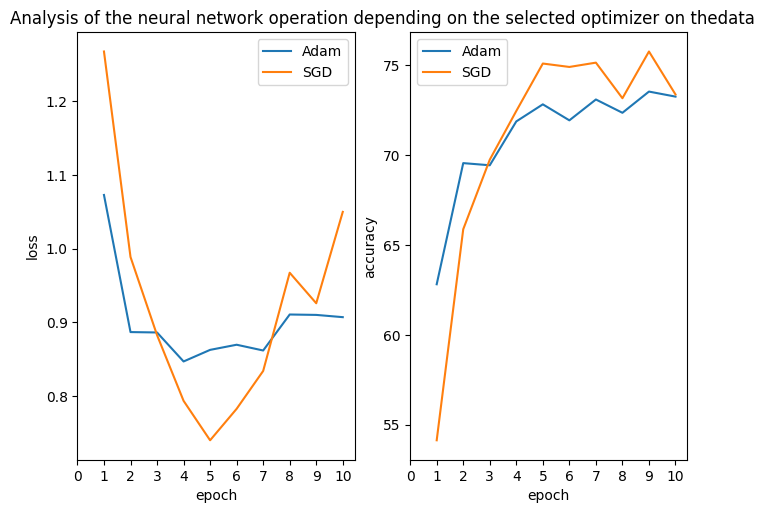

In [11]:
train_and_test(dataload_train, dataload_test)

После того, как отработала предыдущая функция, можем запустить обучения моделей на зашумленных данных. Третий параметр здесь нужен для создания файлов с данными и конечных моделей с суффиксом "noise":

Epoch 1
Accuracy Adam:  60.42
Accuracy SGD:  54.24
Epoch 2
Accuracy Adam:  65.84
Accuracy SGD:  66.66
Epoch 3
Accuracy Adam:  69.98
Accuracy SGD:  70.27
Epoch 4
Accuracy Adam:  69.13
Accuracy SGD:  71.88
Epoch 5
Accuracy Adam:  69.43
Accuracy SGD:  73.92
Epoch 6
Accuracy Adam:  69.99
Accuracy SGD:  74.77
Epoch 7
Accuracy Adam:  71.4
Accuracy SGD:  74.16
Epoch 8
Accuracy Adam:  71.46
Accuracy SGD:  74.64
Epoch 9
Accuracy Adam:  71.0
Accuracy SGD:  73.78
Epoch 10
Accuracy Adam:  71.6
Accuracy SGD:  73.76


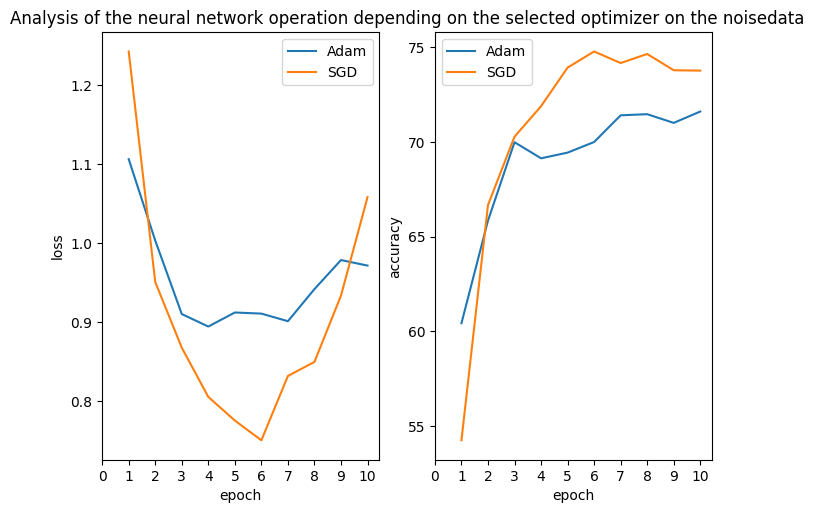

In [12]:
train_and_test(dataload_train_noise, dataload_test, noise = " noise")

В итоге, мы получили 4 разные модели нейронных сетей, попарно обученных на разных датасетах (одни на зашумленном, другие нет), и попарно обученных с использованием разных оптимизаторов. Процесс обучения моделей будет описан в файлах "output_adam.txt", "output_sgd.txt", "output_adam noise.txt" и "output_sgd noise.txt". Также после отработки программы, будут представлены 4 графика работы каждой нейронной сети на тестовых данных, в том числе в файлах "grph.pdf" и "graph noise.pdf".